In [ ]:
# Google Colab에서 Kaggle API를 사용하기 위한 라이브러리 설치
!pip install kaggle

# Kaggle API 토큰 업로드
from google.colab import files
files.upload()

In [ ]:
# Kaggle API 토큰을 사용자 디렉토리로 복사하고 권한 설정
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Kaggle에서 데이터셋 다운로드
!kaggle datasets download -d hetulmehta/website-classification

  0% 0.00/2.00M [00:00<?, ?B/s]
100% 2.00M/2.00M [00:00<00:00, 65.0MB/s]


In [ ]:
# 다운로드한 데이터셋 압축 해제
!unzip website-classification.zip

Archive:  website-classification.zip
  inflating: website_classification.csv  


In [ ]:
# 필요한 패키지 설치
!pip install pandas pgmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.3 MB/s eta 0:00:00


In [ ]:
# 필요한 라이브러리 및 클래스 임포트
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
import networkx as nx
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

In [ ]:
!pip install tqdm

In [ ]:
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=31c21598229f725ee074a1d7fc2b2361e5b27ef1b5ae92195095738f6695c363
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [ ]:
from tqdm import tqdm
import langid

# 데이터 로드
data = pd.read_csv('website_classification.csv')

# 영어 단어 추출을 위한 함수 정의
def is_english(word):
    lang, _ = langid.classify(word)
    return lang == 'en'

# 텍스트에서 영어 단어 추출을 위한 함수 정의
def extract_english_words(text):
    english_words = [word for word in text.split() if is_english(word)]
    return english_words

# 각 행을 처리하는 함수 정의
def process_row(chunk):
    results = []
    for row in chunk:
        if row['Category'] == 'Streaming Services':
            category = row['Category']
            english_words = extract_english_words(row['cleaned_website_text'])
            results.extend([(category, word) for word in english_words])
    return results

# 데이터를 딕셔너리 리스트로 변환
data_list = data.to_dict(orient='records')

# 병렬 처리를 위해 데이터를 청크로 분할
chunk_size = 1000
data_chunks = [data_list[i:i+chunk_size] for i in range(0, len(data_list), chunk_size)]

# 각 청크를 병렬로 처리
with ProcessPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_row, data_chunks), total=len(data_list), desc="Processing Words"))

# 'Streaming Services' 카테고리에 대한 결과 플래튼화
flat_results = [item for sublist in results for item in sublist]

# 새로운 DataFrame 생성
word_data = pd.DataFrame(flat_results, columns=['Category', 'Word'])

Processing Words:   0%|          | 2/1408 [01:08<13:24:40, 34.34s/it]


In [ ]:
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianModel
from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator

# 특징(X) 및 대상 변수(y)로 데이터 분할
X = word_data[['Word']] # 'Word' 열을 특징으로 선택
y = word_data['Category'] # 'Category' 열을 대상 변수로 선택

# 학습 및 테스트 세트로 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bayesian 네트워크 모델 생성
model = BayesianModel([('Word', 'Category')])

# 최대 우도 추정을 사용하여 매개변수 추정
model.fit(word_data, estimator=MaximumLikelihoodEstimator)

In [ ]:
# 추론을 위한 객체 생성
inference = VariableElimination(model)

In [ ]:
# 텍스트 데이터를 bag-of-words 표현으로 변환
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(X)

# 카이제곱 테스트를 사용하여 상위 기능 선택
chi2_stat, p_values = chi2(X_bow, y == 'Streaming Services')

# 기능 이름과 카이제곱 통계량이 포함된 DataFrame 생성
feature_chi2 = pd.DataFrame({'feature': vectorizer.get_feature_names_out(), 'chi2': chi2_stat})

# 'Streaming Services'에 대한 상위 10개 기능 식별
top_streaming_services_features = feature_chi2.sort_values('chi2', ascending=False).head(10)['feature']

# 나머지 카테고리에 대한 상위 기능 식별
top_non_streaming_services_features = feature_chi2.sort_values('chi2', ascending=True).head(10)['feature']

# Directed Graph 생성
graph = nx.DiGraph()

# 'Streaming Services' 및 'Other Categories'를 부모 노드로 추가
graph.add_node('Streaming Services') # 'Streaming Services'를 노드로 추가
graph.add_node('Other Categories') # 'Other Categories'를 노드로 추가

# 상위 기능에 대한 노드 및 엣지 추가
for feature in top_streaming_services_features:
    if feature not in graph.nodes():
        graph.add_node(feature)
    graph.add_edge('Streaming Services', feature)

for feature in top_non_streaming_services_features:
    if feature not in graph.nodes():
        graph.add_node(feature)
    graph.add_edge('Other Categories', feature)

# 레이아웃 설정
pos = nx.kamada_kawai_layout(graph, scale=2.0)
pos['Streaming Services'] = (0, 0)
pos['Other Categories'] = (4, 0)

# Directed Graphs 생성
graph_streaming = nx.DiGraph()
graph_streaming.add_node('Streaming Services')

# 상위 기능에 대한 노드 및 엣지 추가
for feature in top_streaming_services_features:
    if feature not in graph_streaming.nodes():
        graph_streaming.add_node(feature)
    graph_streaming.add_edge('Streaming Services', feature)

# 훈련된 모델을 사용하여 추론 객체 생성
inference_streaming = VariableElimination(model)

# Directed Graphs 생성
graph_other = nx.DiGraph()
graph_other.add_node('Other Categories')

# 상위 기능에 대한 노드 및 엣지 추가
for feature in top_non_streaming_services_features:
    if feature not in graph_other.nodes():
        graph_other.add_node(feature)
    graph_other.add_edge('Other Categories', feature)

# 훈련된 모델을 사용하여 추론 객체 생성
inference_other = VariableElimination(model)

# 레이아웃 설정
pos_streaming = nx.kamada_kawai_layout(graph_streaming, scale=2.0)
pos_other = nx.kamada_kawai_layout(graph_other, scale=2.0)

Conditional Probability for P(tv | Streaming Services): 0.000
Conditional Probability for P(movie | Streaming Services): 0.000
Conditional Probability for P(comedy | Streaming Services): 0.000
Conditional Probability for P(drama | Streaming Services): 0.000
Conditional Probability for P(stream | Streaming Services): 0.000
Conditional Probability for P(tvma | Streaming Services): 0.000
Conditional Probability for P(watch | Streaming Services): 0.000
Conditional Probability for P(streaming | Streaming Services): 0.000
Conditional Probability for P(live | Streaming Services): 0.000
Conditional Probability for P(series | Streaming Services): 0.000
Conditional Probability for P(bird | Other Categories): 0.000
Conditional Probability for P(comparison | Other Categories): 0.000
Conditional Probability for P(employee | Other Categories): 0.000
Conditional Probability for P(depend | Other Categories): 0.000
Conditional Probability for P(gold | Other Categories): 0.000
Conditional Probability fo

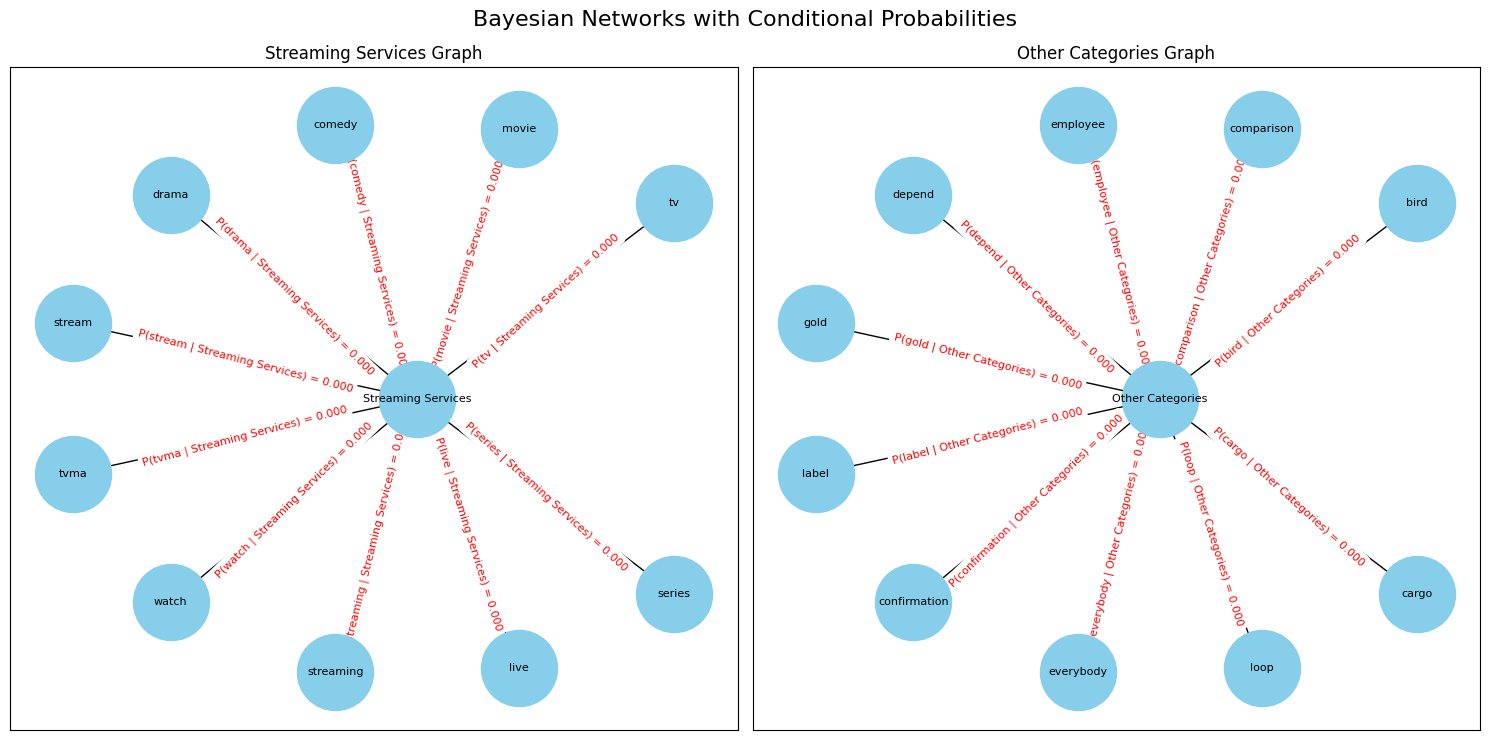

In [ ]:
# 그래프 시각화
plt.figure(figsize=(15, 7.5))
plt.subplot(1, 2, 1)
plt.title('Streaming Services Graph')

# 엣지를 선으로 그리기
nx.draw_networkx_edges(graph_streaming, pos_streaming)
# 노드를 원으로 그리기
nx.draw_networkx_nodes(graph_streaming, pos_streaming, nodelist=graph_streaming.nodes(), node_size=3000, node_color='skyblue')
node_labels_streaming = {node: node for node in graph_streaming.nodes()}
# 노드 레이블 표시
nx.draw_networkx_labels(graph_streaming, pos_streaming, labels=node_labels_streaming, font_size=8, font_color='black')

edge_labels_streaming = {}
for edge in graph_streaming.edges():
    source, target = edge
    try:
        # 'cleaned_website_text' 및 'Category'에서 각 기능의 발생 횟수 계산
        occurrences_source = data[data['cleaned_website_text'].str.contains(source) & (data['Category'] == 'Streaming Services')].shape[0]
        occurrences_target = data[data['cleaned_website_text'].str.contains(target) & (data['Category'] == 'Streaming Services')].shape[0]

        # 조건부 확률 계산
        probability = occurrences_target / occurrences_source if occurrences_source > 0 else 0

        edge_labels_streaming[edge] = f"P({target} | {source}) = {probability:.3f}"

        print(f"Conditional Probability for P({target} | {source}): {probability:.3f}")
    except ValueError as e:
        print(f"Unable to calculate conditional probability for edge {edge}: {str(e)}")

nx.draw_networkx_edge_labels(graph_streaming, pos_streaming, edge_labels=edge_labels_streaming, font_color='red', font_size=8)

# Other Categories 그래프 시각화
plt.subplot(1, 2, 2)
plt.title('Other Categories Graph')
# 엣지를 선으로 그리기
nx.draw_networkx_edges(graph_other, pos_other)
# 노드를 원으로 그리기
nx.draw_networkx_nodes(graph_other, pos_other, nodelist=graph_other.nodes(), node_size=3000, node_color='skyblue')
# 노드 레이블 표시 (상위 특성)
node_labels_other = {node: node for node in graph_other.nodes()}
nx.draw_networkx_labels(graph_other, pos_other, labels=node_labels_other, font_size=8, font_color='black')

# 조건부 확률에 대한 엣지 레이블 표시
edge_labels_other = {}
for edge in graph_other.edges():
    source, target = edge
    try:
        # 'cleaned_website_text' 및 'Category'에서 각 기능의 발생 횟수 계산
        occurrences_source = data[data['cleaned_website_text'].str.contains(source) & (data['Category'] == 'Other Categories')].shape[0]
        occurrences_target = data[data['cleaned_website_text'].str.contains(target) & (data['Category'] == 'Other Categories')].shape[0]

        # 조건부 확률 계산
        probability = occurrences_target / occurrences_source if occurrences_source > 0 else 0

        edge_labels_other[edge] = f"P({target} | {source}) = {probability:.3f}"

        # 조건부 확률 표시
        print(f"Conditional Probability for P({target} | {source}): {probability:.3f}")
    except ValueError as e:
        print(f"Unable to calculate conditional probability for edge {edge}: {str(e)}")

nx.draw_networkx_edge_labels(graph_other, pos_other, edge_labels=edge_labels_other, font_color='red', font_size=8)

# 전체 그림을 위한 주 타이틀 설정
plt.suptitle('Bayesian Networks with Conditional Probabilities', fontsize=16)

plt.tight_layout()  # 겹치지 않도록 레이아웃 조정
plt.show()